In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **1. Library Import & Set path**

In [1]:
import tensorflow as tf

# GPU 사용 가능 여부 확인
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# GPU 이름 확인
if tf.config.list_physical_devices('GPU'):
    print("GPU Device: ", tf.config.list_physical_devices('GPU'))
else:
    print("No GPU detected!")

Num GPUs Available:  1
GPU Device:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# 데이터 경로 설정
train_dir = 'train'
validation_dir = 'validation'
test_dir = 'test'

# **2. Create ImageDataGenerator**

**A. Non Augmentation**

In [4]:
# 데이터 전처리를 위한 ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1.0/255)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# 데이터 생성기 정의
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2912 images belonging to 4 classes.
Found 728 images belonging to 4 classes.
Found 912 images belonging to 4 classes.


In [5]:
print(train_generator.class_indices)  # 클래스 이름과 인덱스 매핑 확인
print(validation_generator.class_indices)
print(test_generator.class_indices)   # 동일하게 매핑되었는지 확인

{'Oblong': 0, 'Oval': 1, 'Round': 2, 'Square': 3}
{'Oblong': 0, 'Oval': 1, 'Round': 2, 'Square': 3}
{'Oblong': 0, 'Oval': 1, 'Round': 2, 'Square': 3}


In [6]:
x, y = next(iter(train_generator))
print(f"Input batch shape: {x.shape}")
print(f"Label batch shape: {y.shape}")

Input batch shape: (32, 224, 224, 3)
Label batch shape: (32, 4)


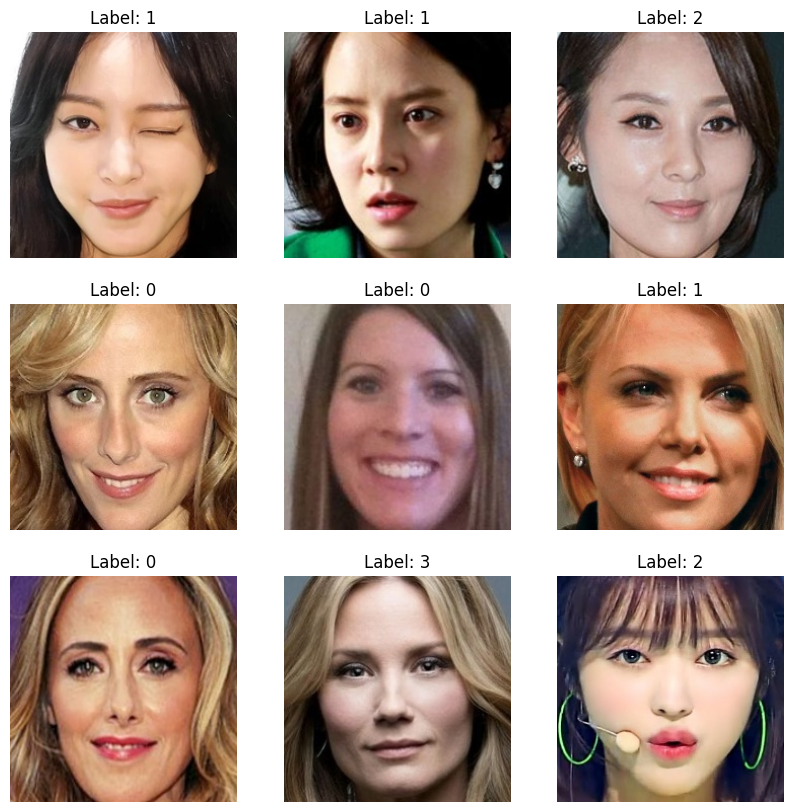

In [7]:
# 첫 번째 배치 가져오기
X_batch, y_batch = next(train_generator)

# 첫 번째 배치에서 몇 개의 이미지를 시각화
plt.figure(figsize=(10, 10))
for i in range(9):  # 첫 9개 이미지
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_batch[i])  # 이미지는 이미 rescale
    plt.title(f"Label: {y_batch[i].argmax()}")  # 원-핫 인코딩된 레이블
    plt.axis("off")
plt.show()

**B. Apply Augmentation**

In [5]:
# 데이터 전처리를 위한 ImageDataGenerator 생성 : 이미지 증강 적용
train_datagen_augmentation = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True, # 좌우 플립
    rotation_range = 20 # 좌우 최대 20도 회전
    )
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# 데이터 생성기 정의
train_generator_augmentation = train_datagen_augmentation.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 2912 images belonging to 4 classes.


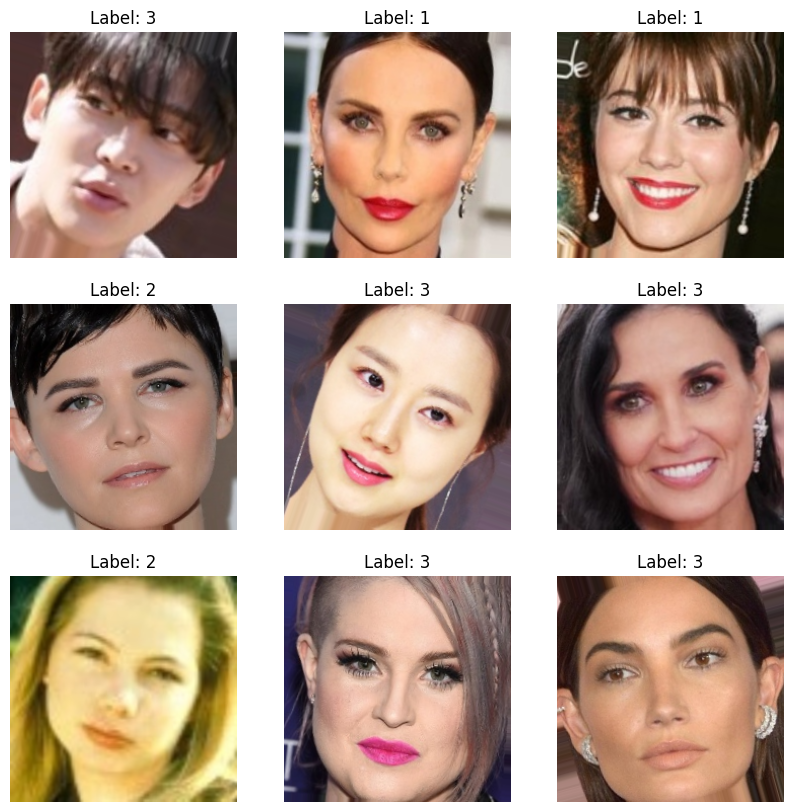

In [9]:
# 첫 번째 배치 가져오기
X_batch, y_batch = next(train_generator_augmentation)

# 첫 번째 배치에서 몇 개의 이미지를 시각화
plt.figure(figsize=(10, 10))
for i in range(9):  # 첫 9개 이미지
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_batch[i])  # 이미지는 이미 rescale
    plt.title(f"Label: {y_batch[i].argmax()}")  # 원-핫 인코딩된 레이블
    plt.axis("off")
plt.show()

# **3. Create Model**

In [6]:
# Path for VGGFace weights
path_vggface = 'rcmalli_vggface_tf_notop_vgg16.h5'

In [7]:
# VGG-16 모델 불러오기 (VGGFace 가중치 사용)
vgg16_base = VGG16(weights=path_vggface, include_top=False, input_shape=(224, 224, 3))

# VGG-16 기본 모델의 가중치를 고정 (학습되지 않도록 설정)
for layer in vgg16_base.layers:
  layer.trainable = False


# 전이 학습을 위한 모델 정의
model = Sequential([
  vgg16_base,
  Flatten(),
  Dense(64, activation='relu'),
  Dropout(0.5),
  Dense(4, activation='softmax')
])

# 모델 컴파일
#optimizer = Adam(learning_rate=0.0001) # FineTuning : 학습률 변경
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 16,320,644
Trainable params: 1,605,956
Non-trainable params: 14,714,688
_________________________________________________________________


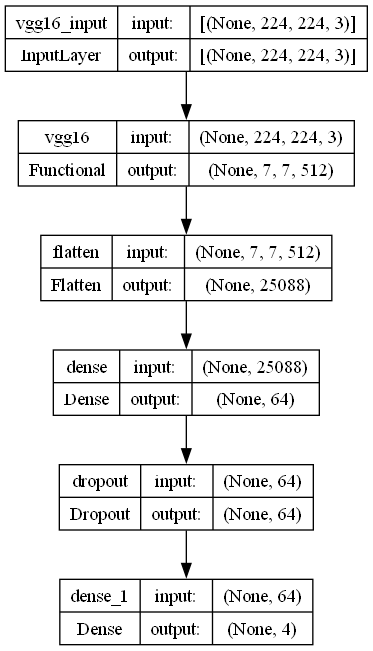

In [8]:
plot_model(model, show_shapes=True, to_file='model.png', show_layer_names=True)

# **4. Model Training**

**A. Non Augmentation**

In [9]:
# 모델 훈련
history = model.fit(
    train_generator,           # train_generator를 전달
    epochs=30,
    validation_data=validation_generator  # validation_generator를 전달
)

Epoch 1/30
91/91 [==============================] - 11s 81ms/step - loss: 0.8999 - accuracy: 0.6456 - val_loss: 0.5812 - val_accuracy: 0.7981
Epoch 2/30
91/91 [==============================] - 6s 63ms/step - loss: 0.5348 - accuracy: 0.8073 - val_loss: 0.4732 - val_accuracy: 0.8242
Epoch 3/30
91/91 [==============================] - 6s 63ms/step - loss: 0.3910 - accuracy: 0.8554 - val_loss: 0.3995 - val_accuracy: 0.8681
Epoch 4/30
91/91 [==============================] - 6s 64ms/step - loss: 0.3125 - accuracy: 0.8949 - val_loss: 0.3805 - val_accuracy: 0.8640
Epoch 5/30
91/91 [==============================] - 6s 63ms/step - loss: 0.2355 - accuracy: 0.9241 - val_loss: 0.3643 - val_accuracy: 0.8791
Epoch 6/30
91/91 [==============================] - 6s 63ms/step - loss: 0.1917 - accuracy: 0.9416 - val_loss: 0.3500 - val_accuracy: 0.8860
Epoch 7/30
91/91 [==============================] - 6s 63ms/step - loss: 0.1557 - accuracy: 0.9523 - val_loss: 0.3647 - val_accuracy: 0.8695
Epoch 8/30
9

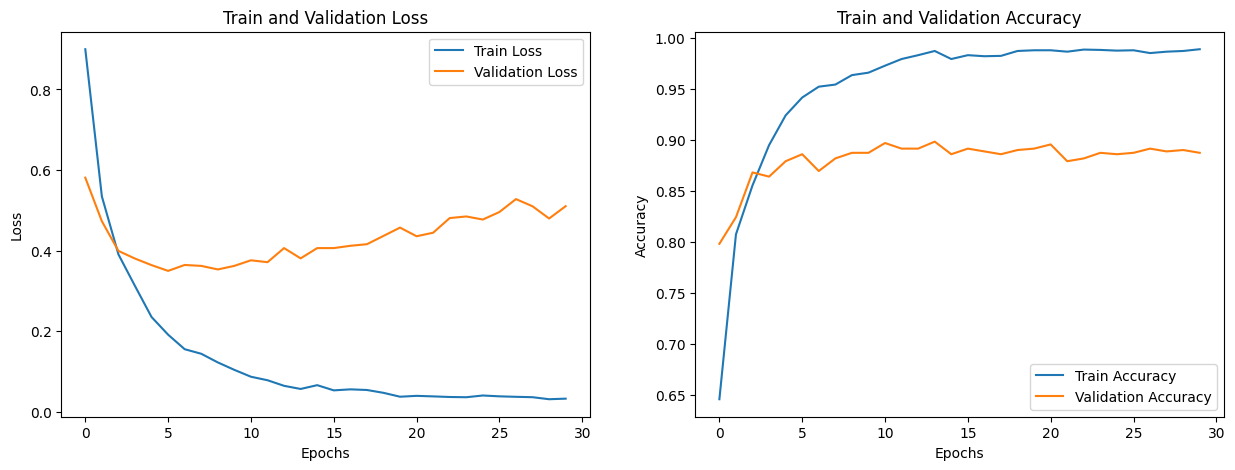

In [10]:
plt.figure(figsize=(15, 5))

# 1. Train과 Validation 셋에 대한 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# 2. Train과 Validation 셋에 대한 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

In [11]:
# 3. 혼동행렬
# 예측 값과 실제 값을 얻기 위해 테스트 셋 예측
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
# loss, accuracy = model.evaluate(test_generator)
# print(loss, accuracy)

29/29 [==============================] - 4s 142ms/step


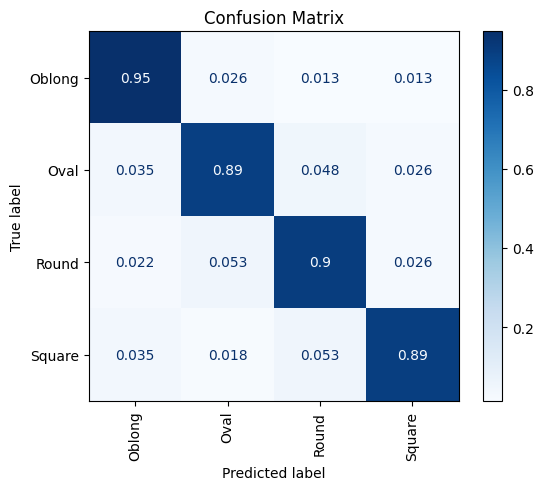

In [12]:
# 혼동행렬 계산 및 정규화
cm = confusion_matrix(y_true, y_pred_classes, normalize='true')
labels = list(test_generator.class_indices.keys())
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

**B. Apply Augmentation**

In [13]:
# 전이 학습을 위한 모델 정의
model_2 = Sequential([
  vgg16_base,
  Flatten(),
  Dense(64, activation='relu'),
  Dropout(0.5),
  Dense(4, activation='softmax')
])

# 모델 컴파일
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1605696   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 16,320,644
Trainable params: 1,605,956
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
# 모델 훈련
history_2 = model_2.fit(
    train_generator_augmentation,           # train_generator를 전달
    epochs=30,
    validation_data=validation_generator  # validation_generator를 전달
)

Epoch 1/30
91/91 [==============================] - 13s 138ms/step - loss: 0.9638 - accuracy: 0.5903 - val_loss: 0.6347 - val_accuracy: 0.7665
Epoch 2/30
91/91 [==============================] - 13s 137ms/step - loss: 0.6563 - accuracy: 0.7490 - val_loss: 0.5035 - val_accuracy: 0.8159
Epoch 3/30
91/91 [==============================] - 12s 137ms/step - loss: 0.5498 - accuracy: 0.7857 - val_loss: 0.4595 - val_accuracy: 0.8365
Epoch 4/30
91/91 [==============================] - 13s 138ms/step - loss: 0.4692 - accuracy: 0.8300 - val_loss: 0.3989 - val_accuracy: 0.8571
Epoch 5/30
91/91 [==============================] - 13s 137ms/step - loss: 0.4187 - accuracy: 0.8486 - val_loss: 0.4013 - val_accuracy: 0.8599
Epoch 6/30
91/91 [==============================] - 13s 140ms/step - loss: 0.3905 - accuracy: 0.8575 - val_loss: 0.3601 - val_accuracy: 0.8750
Epoch 7/30
91/91 [==============================] - 13s 138ms/step - loss: 0.3511 - accuracy: 0.8781 - val_loss: 0.3468 - val_accuracy: 0.8805

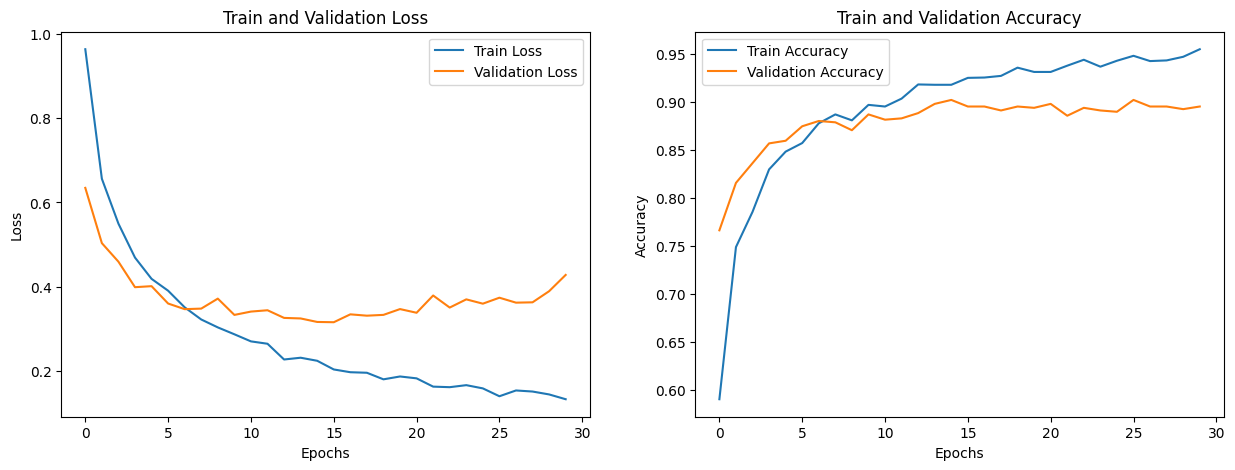

In [15]:
plt.figure(figsize=(15, 5))

# 1. Train과 Validation 셋에 대한 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# 2. Train과 Validation 셋에 대한 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

In [16]:
# 3. 혼동행렬
# 예측 값과 실제 값을 얻기 위해 테스트 셋 예측
y_true = test_generator.classes
y_pred = model_2.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
# loss, accuracy = model.evaluate(test_generator)
# print(loss, accuracy)

29/29 [==============================] - 1s 48ms/step


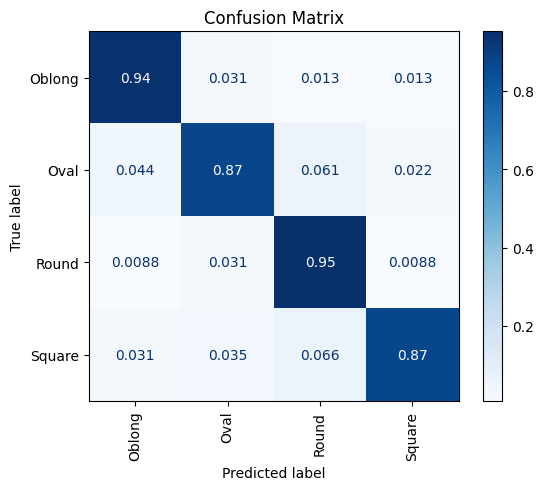

In [17]:
# 혼동행렬 계산 및 정규화
cm = confusion_matrix(y_true, y_pred_classes, normalize='true')
labels = list(test_generator.class_indices.keys())
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# 모델 저장
model.save('face_shape_vgg16_transfer.h5')

print("VGG-16 기반 전이 학습 완료 및 모델 저장 완료.")

VGG-16 기반 전이 학습 완료 및 모델 저장 완료.


In [19]:
import tensorflow as tf

# Keras 모델 로드
model = tf.keras.models.load_model('face_shape_vgg16_transfer.h5')

# TFLite 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 변환된 모델 저장
with open('face_analysis_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\PEJ\AppData\Local\Temp\tmpt665426t\assets


INFO:tensorflow:Assets written to: C:\Users\PEJ\AppData\Local\Temp\tmpt665426t\assets
